# Integrating Product Design and Supply Chain Design

## Import Packages

In [75]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum as qsum
import pandas as pd
from pandas import DataFrame, read_csv
import random
import math

import sys
sys.path.append('../')
import saedfsc

## Parameters

In [76]:
numAssemblyOptions = 2
numSuppliersPerPart = 2

## Get Part Options

In [77]:
partOptions = saedfsc.getPartOptionsWithSuppliers()
partOptions['tires']

,Unnamed: 0_x,Pressure Rating,pressure,pressure (Ordering Pressure Ratings),Unnamed: 0_y,ID,radius,mass,cost,radius (Ordering tires),Suppliers
0,0,Basic,0.758,0.758,0,T1,0.22860,3.636,300,0.22860,"[Supplier3, Supplier4, Supplier2]"
1,0,Basic,0.758,0.758,1,T2,0.22987,4.091,302,0.22987,[Supplier5]
2,0,Basic,0.758,0.758,2,T3,0.23241,4.545,306,0.23241,[Supplier4]
3,0,Basic,0.758,0.758,3,T4,0.24638,4.545,324,0.24638,"[Supplier5, Supplier4, Supplier2]"
4,0,Basic,0.758,0.758,4,T5,0.24765,5.000,326,0.24765,"[Supplier6, Supplier4, Supplier7]"
5,0,Basic,0.758,0.758,5,T8,0.26162,5.455,344,0.26162,[Supplier5]
6,0,Basic,0.758,0.758,6,T6,0.26670,5.000,352,0.26670,[Supplier1]
7,1,Low,0.834,0.834,0,T1,0.22860,3.636,300,0.22860,[Supplier3]
8,1,Low,0.834,0.834,1,T2,0.22987,4.091,302,0.22987,"[Supplier7, Supplier4]"
9,1,Low,0.834,0.834,2,T3,0.23241,4.545,306,0.23241,[Supplier3]


## Suppliers

In [78]:
saedfsc.suppliers

,Name,Location,Rating,SetUpCost,Cost Per Unit,Time Per Unit
0,Supplier1,Location3,3.536724,4665,9,8
1,Supplier2,Location2,3.202017,4095,5,3
2,Supplier3,Location4,4.723231,1178,8,9
3,Supplier4,Location1,2.719848,2503,4,2
4,Supplier5,Location3,4.765031,4383,8,7
5,Supplier6,Location3,4.470437,3035,2,4
6,Supplier7,Location3,2.462482,3477,1,8


## Create Components and Assemblies

In [79]:

components = []
componentsForSubsystems = {}
subsystemsForComponents = {}
for subsystem in partOptions.keys():
    if subsystem == 'wings':
        toAdd = ['rear wing', 'front wing', 'side wing']
        for c in toAdd:
            components.append(c)
            subsystemsForComponents[c] = subsystem
        componentsForSubsystems[subsystem] = toAdd
    elif subsystem == 'tires':
        toAdd = ['front tire', 'rear tire']
        for c in toAdd:
            components.append(c)
            subsystemsForComponents[c] = subsystem
        componentsForSubsystems[subsystem] = toAdd
    elif subsystem == 'suspension':
        toAdd = ['front suspension', 'rear suspension']
        for c in toAdd:
            components.append(c)
            subsystemsForComponents[c] = subsystem
        componentsForSubsystems[subsystem] = toAdd
    else:
        components.append(subsystem)
        componentsForSubsystems[subsystem] = [subsystem]
        subsystemsForComponents[subsystem] = subsystem
assembliesStructure = {'midbody' : ['engine', 'cabin', 'side wing'], 
                       'front' : ['front wing', 'front tire', 'impactattenuator', 'front suspension'], 
                       'rear' : ['rear wing', 'brakes', 'rear tire', 'rear suspension'],}
assemblyNodes = list(assembliesStructure.keys())
finalNodes = ['FINAL']
allNodes = components + assemblyNodes + finalNodes
nonComponentNodes = assemblyNodes + finalNodes
print(components)
print(allNodes)

['rear wing', 'front wing', 'side wing', 'front tire', 'rear tire', 'engine', 'cabin', 'impactattenuator', 'brakes', 'front suspension', 'rear suspension']
['rear wing', 'front wing', 'side wing', 'front tire', 'rear tire', 'engine', 'cabin', 'impactattenuator', 'brakes', 'front suspension', 'rear suspension', 'midbody', 'front', 'rear', 'FINAL']


## Display Graph

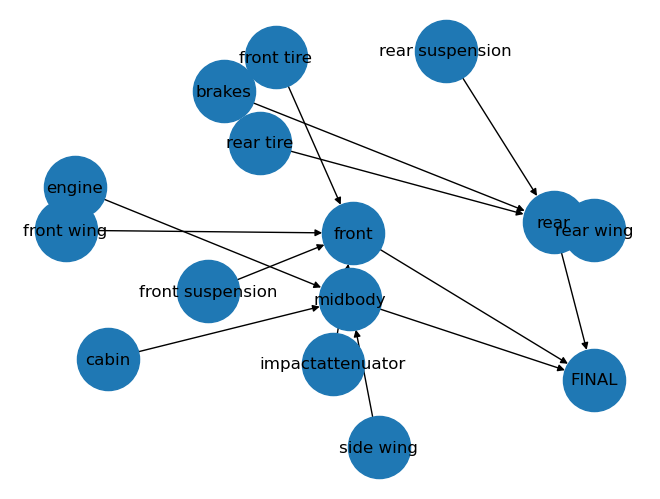

In [80]:
G = nx.DiGraph()

numNodes = len(components) + len(assemblyNodes) + len(finalNodes)

np.random.seed(0)
stageCostsList = np.random.randint(1, 10, numNodes)
processTimesList = np.random.randint(1, 10, numNodes)
maxServiceTimeOutList = 20*np.ones(numNodes)
maxServiceTimeOutList[numNodes-1] = 0

for n in allNodes:
    time = np.random.randint(1, 10)
    G.add_node(n, process_time=time, 
               max_service_time_out=2*time,
               stage_cost=np.random.randint(1, 10))

for n in assemblyNodes:
    for component in assembliesStructure[n]:
        G.add_edge(component, n)

for n in assemblyNodes:
    for n2 in finalNodes:
        G.add_edge(n, n2)

maxServiceTimeOut = nx.get_node_attributes(G, 'max_service_time_out')

nx.draw(G, with_labels=True, node_size=2000)
plt.show()

In [81]:
# G = nx.DiGraph()

# numNodes = 6
# numOptions = 2

# np.random.seed(0)
# stageCostsList = np.random.randint(1, 10, numNodes)
# processTimesList = np.random.randint(1, 10, numNodes)
# maxServiceTimeOutList = 20*np.ones(numNodes)
# maxServiceTimeOutList[numNodes-1] = 0

# for i in range(numNodes):
#     G.add_node(i+1, process_time=processTimesList[i], 
#                max_service_time_out=maxServiceTimeOutList[i],
#                stage_cost=stageCostsList[i])

# maxServiceTimeOut = nx.get_node_attributes(G, 'max_service_time_out')

# # Add edges between nodes to create the tree
# G.add_edge(1, 3)
# G.add_edge(2, 3)
# G.add_edge(1, 6)
# G.add_edge(2, 6)
# G.add_edge(3, 6)
# G.add_edge(4, 6)
# G.add_edge(5, 6)

# # Draw the graph
# nx.draw(G, with_labels=True)
# plt.show()

## Options for Each Node (Component or Assembly)

In [82]:
optionsInfo = {}
optionsForSubSysAndPart = {}
numOptionsForNode = {}
for n in G.nodes():
    if n in components:
        k = 0
        subsys = subsystemsForComponents[n]
        for p in partOptions[subsys].index.values:
            optionsForSubSysAndPart[subsys,p] = []
            for supplier in partOptions[subsys].loc[p, 'Suppliers'].tolist():
                cost_per_unit = saedfsc.suppliers[saedfsc.suppliers['Name'] == supplier]['Cost Per Unit'].values[0]
                time_per_unit = saedfsc.suppliers[saedfsc.suppliers['Name'] == supplier]['Time Per Unit'].values[0]
                optionsInfo[n,k] = {'cost' : cost_per_unit, 'time' : time_per_unit}
                optionsForSubSysAndPart[subsys,p].append(k)
                k += 1
        numOptionsForNode[n] = k
    else:
        numOptionsForNode[n] = numAssemblyOptions
        for k in range(numAssemblyOptions):
            optionsInfo[n,k] = {'cost' : np.random.randint(1, 10), 'time' : np.random.randint(1, 10)}

flattened_optionsInfo = {(i,k): values for (i,k), values in optionsInfo.items()}

df = pd.DataFrame.from_dict(flattened_optionsInfo, orient='index')

df.reset_index(inplace=True)
df.columns = ['Node', 'Option', 'Cost', 'Time']
df

,Node,Option,Cost,Time
0,rear wing,0,2,4
1,rear wing,1,8,9
2,rear wing,2,8,9
3,rear wing,3,4,2
4,rear wing,4,4,2
...,...,...,...,...
472,front,1,4,3
473,rear,0,4,5
474,rear,1,2,3
475,FINAL,0,2,5


In [83]:
# optionsInfo = {}
# for i in range(numNodes):
#     for k in range(numOptions):
#         optionsInfo[i+1,k] = {'cost' : np.random.randint(1, 10), 'time' : np.random.randint(1, 10)}

# flattened_optionsInfo = {(i,k): values for (i,k), values in optionsInfo.items()}

# df = pd.DataFrame.from_dict(flattened_optionsInfo, orient='index')

# df.reset_index(inplace=True)
# df.columns = ['Node', 'Option', 'Cost', 'Time']
# df

## Customers

In [84]:
customersDF = saedfsc.getCustomersDF()
customerTypes = customersDF['Name'].to_list()
meanDemandForCustomerType = {c : np.random.randint(1, 20) for c in customerTypes}
stDevDemandForCustomerType = {c : 3 for c in customerTypes}
meanDemands = dict(zip(customersDF['Name'], customersDF['Mean Demand']))
stdDevDemands = dict(zip(customersDF['Name'], customersDF['Std Dev Demand']))
cPriceFocus = dict(zip(customersDF['Name'], customersDF['PriceFocus']))
#name_weights_partworth_dict = customersDF.set_index('Name')['PartworthUtilityWeights'].to_dict()
name_weights_perf_dict = customersDF.set_index('Name')['PerformanceUtilityWeights'].to_dict()
#cWtsPartworth = {c : np.fromstring(name_weights_partworth_dict[c].strip('[]'), sep=',') for c in name_weights_partworth_dict}
cWtsPerf = {c : np.fromstring(name_weights_perf_dict[c].strip('[]'), sep=',') for c in name_weights_perf_dict}
customersDF

,Name,Quantity,Mean Demand,Std Dev Demand,PriceFocus,PartworthUtilityWeights,PerformanceUtilityWeights
0,CustomerType1,785,16,3,0.943944,"[0.15911931,0.31794878,0.60614632,0.11971278,0...","[0.07353441,0.23812319,0.88198825,0.18071148,0..."
1,CustomerType2,127,21,3,0.392428,"[0.78091746,0.76884294,0.09853732,0.42630513,0...","[0.06854985,0.53773759,0.93934427,0.94031569,0..."
2,CustomerType3,966,20,1,0.324017,"[0.65919069,0.33134067,0.9477402 ,0.70901273,0...","[0.98918637,0.95977688,0.30505229,0.96212633,0..."


## Objectives (Performance Metrics)

In [85]:
objectives = ['mass', 'center of gravity', 'drag', 'downforce', 'acceleration', 
              'crash force', 'attenuator volume', 'cornering velocity', 
              'braking distance', 'suspension acceleration', 'pitch moment']
objIndices = range(len(objectives))

## Define Parameters and Sets

In [86]:
meanDemand = 5
stdDevDemand = 3
holdingCostRate = 1
safetyFactor = 2
betaMult = 5
numComponentsRequired = len(components) - 1
price = 20000
maxProductPrice = 30000

holdCostCoef = holdingCostRate*safetyFactor

# procureNodes = [1,2,4,5]
# assemblyNodes = [3]
# finalNodes = [6]

## Parameters for COTSCar Model

In [87]:
random.seed(10) # Since uniform distribution used in center of gravity constraints

v_car = 26.8 #m/s
omega_e = 3600 #rpm
rho_air = 1.225 #kg/m^3
r_track = 9 #m
P_brk = 1 * (10 ** 7) #Pa
g = 9.81 #m/s^2
y_parameter = 0.05 #m
y_dot_parameter = 0.025 #m/s
c_brk = 0.37 # Coefficient of Brake Friction
l_f = 0.5 # Pitch Moment Parameter
C_lat = 1.6 # Cornering Velocity parameter in Dr. McComb code

# Car performance objectives minimum values
objectives_min = [95.4413,
                  0.1159,
                  4.8283,
                  0.006299,
                  0.0,
                  1636425.0,
                  0.004049,
                  0.01908,
                  5.9088,
                  9.81,
                  0.03386]

# Car performance objectives maximum values
objectives_max = [5593.26,
                   0.9996,
                   633.95,
                   3211.16,
                   4.35,
                   672530217,
                   0.1579,
                   15.0652,
                   553.92,
                   18.79,
                   9850.87]

# Weights of each car performance term in objective function (Scenario 1)
performance_weights = [0.14, 0.01, 0.20, 0.30, 0.10, 0.01, 0.01, 0.10, 0.10, 0.02, 0.01] 

## Convenience Methods

This method is a placeholder until we model competitors using the competitors DataFrame.

In [88]:
numCompetitors = 2
minUtil = 1000000000
maxUtil = 1500000000
totalUtiltityForCompetitors = {c : sum(np.random.randint(minUtil, maxUtil, numCompetitors)) 
                               for c in customerTypes} # 

def getSqrtTotalUtilityForCompetitors(customerType : int):
    return np.sqrt(totalUtiltityForCompetitors[customerType])

## Create Model and Add Variables

In [89]:
m = gp.Model("safety stock")

stdDevDemandVar = m.addVar(name="stdDevDemand")
meanDemandVar = m.addVar(name="meanDemand")
marketShare = m.addVars(customerTypes, ub = 1, name="marketShare")
customerUtil = m.addVars(customerTypes, name="customerUtil")
componentSelect = m.addVars(components, vtype=GRB.BINARY, 
                            name="componentSelect")
arcSelect = m.addVars(G.edges(), vtype=GRB.BINARY, name="arcSelect")
stageTime = m.addVars(G.nodes(), vtype=GRB.INTEGER, 
                    name="stageTime")
stageCost = m.addVars(G.nodes(), vtype=GRB.INTEGER, 
                    name="stageCost")
sIn = m.addVars(G.nodes(), vtype=GRB.INTEGER, name="sIn")
sOut = m.addVars(G.nodes(), ub = maxServiceTimeOut, vtype=GRB.INTEGER, 
                 name="sOut")
netTime = m.addVars(G.nodes(), ub = sum(processTimesList), vtype=GRB.INTEGER, 
                    name="netTime")
sqrtNetTime = m.addVars(G.nodes(), vtype=GRB.INTEGER, name="sqRootnetTime")
cumCostVar = m.addVars(G.nodes(), name="cumCost")

stdDevDemandTimesCumCostVar = m.addVars(G.nodes(), 
                                        name="stdDevDemandTimesCumCost")
meanDemandTimesStageTimeVar = m.addVars(G.nodes(), 
                                        name="meanDemandTimesStageTime");

This variable holds the value for each of the performance objectives.

In [90]:
z = m.addVars(objectives, 
                    name="objValVar") #normalized to [0,1], where 1 is best

This variable selections which option to use for each node (components, assemblies, and the final node). An option determines both the part as well as a supplier

In [91]:
optionSelect = m.addVars(optionsInfo.keys(), vtype=GRB.BINARY, 
                            name="optionSelect")

This variable determines which part is used for each component.

In [92]:
x = {} # part selection variables (parts to use for each component)
for subsystem in partOptions.keys():
    for c in componentsForSubsystems[subsystem]:
        x[c] = m.addVars(partOptions[subsystem].index.values, vtype=GRB.BINARY, name="x_{0}".format(c))

## Add Variables for Car Design

In [93]:
u_e_mTotal = m.addVars(partOptions['engine'].index.values, vtype = GRB.CONTINUOUS, name = "u_e_mTotal") # x_e * mTotal Equivalency Variable
u_rootMass = m.addVar(1, vtype = GRB.CONTINUOUS, name = 'u_rootMass') # square root of total mass equivalence variable
u_rt_brkDistance = m.addVars(partOptions['tires'].index.values, vtype = GRB.CONTINUOUS, name = 'u_rt_downforce') # Rear Tire and Downforce Equivalency Variable
u_rt_pressure_inverse = m.addVars(partOptions['tires'].index.values, vtype = GRB.CONTINUOUS, name = 'u_rt_pressure_inverse') # Inverse of rear tire pressure for C calculation
u_rw_c = m.addVars(partOptions['wings'].index.values, partOptions['cabin'].index.values, vtype = GRB.BINARY, name = 'u_rw_c') # rear wing and cabin equivalence variable
u_fw_c = m.addVars(partOptions['wings'].index.values, partOptions['cabin'].index.values, vtype = GRB.BINARY, name = 'u_fw_c') # front wing and cabin equivalence variable
u_sw_c = m.addVars(partOptions['wings'].index.values, partOptions['cabin'].index.values, vtype = GRB.BINARY, name = 'u_sw_c') # side wing and cabin equivalence variable

## Methods to Help in Creating Model

In [94]:
def outFlowSum(i):
    return qsum(arcSelect[i,j] for j in G.successors(i))

def inFlowSum(i): 
    return qsum(arcSelect[j,i] for j in G.predecessors(i))

def getUtilityForProduct(customer : int):
    pricePerf = (maxProductPrice - price) / maxProductPrice # Normalized price (0 is best, 1 is worst)
    product_utility = qsum(cWtsPerf[customer][o]*z[objectives[o]] for o in objIndices)
    return (1-cPriceFocus[customer])*product_utility + cPriceFocus[customer]*pricePerf

## Add Constraints and Objective

In [95]:
m.addConstrs((qsum(optionSelect[c,k] for k in optionsForSubSysAndPart[subsystem, p]) == x[c][p] 
                   for subsystem in partOptions.keys()
                   for c in componentsForSubsystems[subsystem]
                   for p in partOptions[subsystem].index.values), 
             "options-for-part")
m.addConstrs((stageCost[i] == qsum(optionsInfo[i,k]['cost']*optionSelect[i,k] 
                                   for k in range(numOptionsForNode[i])) 
              for i in G.nodes()), 
              name="StageCostCalc")
m.addConstrs((stageTime[i] == qsum(optionsInfo[i,k]['time']*optionSelect[i,k] 
                                   for k in range(numOptionsForNode[i])) 
              for i in G.nodes()), 
              name="StageTimeCalc")
m.addConstrs((cumCostVar[j] == stageCost[j] + qsum(cumCostVar[i]*arcSelect[i,j] 
                                                    for i in G.predecessors(j)) 
                                                    for j in G.nodes()), 
             name="calcCumCost")
m.addConstrs((sIn[j] >= sOut[i]*arcSelect[i,j] for i,j in G.edges()), 
             name="sInGreater")
m.addConstrs((optionSelect.sum(i,'*') == componentSelect[i] for i in components), 
             "select1-component")
m.addConstrs((optionSelect.sum(i,'*') == 1 for i in nonComponentNodes), 
             "select1-other")
m.addConstrs((inFlowSum(i) == G.in_degree(i)*outFlowSum(i) for i in assemblyNodes), 
             name="netFlow")
m.addConstrs((qsum(arcSelect[i,j] for j in G.successors(i)) == componentSelect[i] 
              for i in components), 
             name="sumOutFlow")
m.addConstrs((arcSelect[i,j] <= componentSelect[i] 
              for i,j in G.edges() if i in components), 
              "useArcIfNode")
m.addConstrs((sIn[i] == 0 for i in components), 
             name="procureNodesInTime")
m.addConstrs((netTime[i] == sIn[i] + stageTime[i] - sOut[i] 
              for i in G.nodes()), 
              name="NetTimeCalc")
m.addConstrs((netTime[i] == sqrtNetTime[i]*sqrtNetTime[i] 
              for i in G.nodes()), 
             name="SqRootNetTimeCalc")
m.addConstrs((stdDevDemandTimesCumCostVar[i] == stdDevDemandVar*cumCostVar[i] 
              for i in G.nodes()), 
             name="stdDevDemandTimesCumCostVar")
m.addConstrs((meanDemandTimesStageTimeVar[i] == meanDemandVar*stageTime[i] 
              for i in G.nodes()), 
             name="meanDemandTimesStageTimeVar")
m.addConstr(meanDemandVar == qsum(meanDemandForCustomerType[c]*marketShare[c] for c in customerTypes), 
            name="meanDemandVar")
m.addConstr(stdDevDemandVar**2 <= qsum(stDevDemandForCustomerType[c]**2*marketShare[c]**2 
                                       for c in customerTypes), 
            name="stdDevDemandVar")
m.addConstrs((customerUtil[c]**2 <= getUtilityForProduct(c) 
              for c in customerTypes), 
             name="customerUtilCalc") #sqrt utility function (diminishing returns)
m.addConstrs((customerUtil[c] == getSqrtTotalUtilityForCompetitors(c)*marketShare[c] + customerUtil[c]*marketShare[c] 
              for c in customerTypes), # linearized form of logit function
             name="marketShareCalc")

# placeholder constraints to make example work
m.addConstr(qsum(componentSelect[i] for i in components) == 11, # all components must be used
             name="componentsRequired")

m.setObjective(price*meanDemandVar 
               - qsum(holdCostCoef*stdDevDemandTimesCumCostVar[i]*sqrtNetTime[i] 
                    + holdingCostRate*(cumCostVar[i] - stageCost[i]/2)*meanDemandTimesStageTimeVar[i]
                    + betaMult*stageCost[i]*meanDemandVar
                                            for i in G.nodes()), 
                                                GRB.MAXIMIZE); # maximize expected profit

In [96]:
# Mass Constraints

rw_mass = gp.quicksum(partOptions['wings'].loc[part]['length'] * 
                      partOptions['wings'].loc[part]['width'] * 
                      partOptions['wings'].loc[part]['height'] * 
                      partOptions['wings'].loc[part]['q'] *
                      x['rear wing'][part] for part in partOptions['wings'].index.values)

fw_mass = gp.quicksum(partOptions['wings'].loc[part]['length'] * 
                      partOptions['wings'].loc[part]['width'] * 
                      partOptions['wings'].loc[part]['height'] * 
                      partOptions['wings'].loc[part]['q'] *
                      x['front wing'][part] for part in partOptions['wings'].index.values)

sw_mass = gp.quicksum(partOptions['wings'].loc[part]['length'] * 
                      partOptions['wings'].loc[part]['width'] * 
                      partOptions['wings'].loc[part]['height'] * 
                      partOptions['wings'].loc[part]['q'] *
                      x['rear wing'][part] for part in partOptions['wings'].index.values)

ft_mass = gp.quicksum(partOptions['tires'].loc[part]['mass'] * 
                      x['front tire'][part] for part in partOptions['tires'].index.values)

rt_mass = gp.quicksum(partOptions['tires'].loc[part]['mass'] * 
                      x['rear tire'][part] for part in partOptions['tires'].index.values)

c_mass = 2 * gp.quicksum(partOptions['cabin'].loc[part]['thickness'] * 
                         (partOptions['cabin'].loc[part]['length'] * 
                          partOptions['cabin'].loc[part]['width'] + 
                          partOptions['cabin'].loc[part]['length'] * 
                          partOptions['cabin'].loc[part]['height'] + 
                          partOptions['cabin'].loc[part]['width'] * 
                          partOptions['cabin'].loc[part]['height']) * 
                         partOptions['cabin'].loc[part]['q'] * 
                         x['cabin'][part] for part in partOptions['cabin'].index.values)

e_mass = gp.quicksum(partOptions['engine'].loc[part]['Mass'] * 
                     x['engine'][part] for part in partOptions['engine'].index.values)

ia_mass = gp.quicksum(partOptions['impactattenuator'].loc[part]['length'] * 
                      partOptions['impactattenuator'].loc[part]['width'] * 
                      partOptions['impactattenuator'].loc[part]['height'] * 
                      partOptions['impactattenuator'].loc[part]['q'] * 
                      x['impactattenuator'][part] for part in partOptions['impactattenuator'].index.values)

brk_mass = gp.quicksum(partOptions['brakes'].loc[part]['lbrk'] * 
                       partOptions['brakes'].loc[part]['wbrk'] * 
                       partOptions['brakes'].loc[part]['hbrk'] * 
                       partOptions['brakes'].loc[part]['qbrk'] * 
                       1000 * 
                       x['brakes'][part] for part in partOptions['brakes'].index.values)
                      
rsp_mass = gp.quicksum(partOptions['suspension'].loc[part]['mrsp'] * 
                       x['rear suspension'][part] for part in partOptions['suspension'].index.values)

fsp_mass = gp.quicksum(partOptions['suspension'].loc[part]['mfsp'] * 
                       x['front suspension'][part] for part in partOptions['suspension'].index.values)
                      
total_mass = (rw_mass + fw_mass + (2 * sw_mass) + (2 * ft_mass) + (2 * rt_mass) +
             c_mass + e_mass + ia_mass + (4 * brk_mass) + (2 * rsp_mass) + (2 * fsp_mass))
    
m.addConstr(z['mass'] == total_mass)
m.update()

In [97]:
# Center of Gravity Constraints

rw_position_y = gp.quicksum(np.random.uniform(0.5 + (partOptions['wings'].loc[part]['height'] / 2), 
                                              1.2 - (partOptions['wings'].loc[part]['height'] / 2)) *
                                              x['rear wing'][part] for part in partOptions['wings'].index.values)

fw_position_y = gp.quicksum(np.random.uniform(0.03 + (partOptions['wings'].loc[part]['height'] / 2), 
                                              0.25 - (partOptions['wings'].loc[part]['height'] / 2)) *
                                              x['front wing'][part] for part in partOptions['wings'].index.values)

sw_position_y = gp.quicksum(np.random.uniform(0.03 + (partOptions['wings'].loc[part]['height'] / 2), 
                                              0.25 - (partOptions['wings'].loc[part]['height'] / 2)) * 
                                              x['side wing'][part] for part in partOptions['wings'].index.values)

rt_position_y = gp.quicksum(partOptions['tires'].loc[part]['radius'] * 
                            x['rear tire'][part] for part in partOptions['tires'].index.values)

ft_position_y = gp.quicksum(partOptions['tires'].loc[part]['radius'] * 
                            x['front tire'][part] for part in partOptions['tires'].index.values)

c_position_y = gp.quicksum(np.random.uniform(0.03 + (partOptions['cabin'].loc[part]['height'] / 2), 
                                             1.2 - (partOptions['cabin'].loc[part]['height'] / 2)) * 
                                             x['cabin'][part] for part in partOptions['cabin'].index.values)

e_position_y = gp.quicksum(np.random.uniform(0.03 + (partOptions['engine'].loc[part]['Height'] / 2), 
                                             0.50 - (partOptions['engine'].loc[part]['Height'] / 2)) * 
                                             x['engine'][part] for part in partOptions['engine'].index.values)

ia_position_y = gp.quicksum(np.random.uniform(0.03 + (partOptions['impactattenuator'].loc[part]['height'] / 2), 
                                              1.20 - (partOptions['impactattenuator'].loc[part]['height'] / 2)) * 
                                              x['impactattenuator'][part] for part in partOptions['impactattenuator'].index.values)

brk_position_y = gp.quicksum(partOptions['tires'].loc[part]['radius'] * 
                             x['front tire'][part] for part in partOptions['tires'].index.values)

rsp_position_y = gp.quicksum(np.random.uniform(partOptions['tires'].loc[part]['radius'], 
                                               2 * partOptions['tires'].loc[part]['radius']) * 
                                               x['rear tire'][part] for part in partOptions['tires'].index.values)

fsp_position_y = gp.quicksum(np.random.uniform(partOptions['tires'].loc[part]['radius'], 
                                               2 * partOptions['tires'].loc[part]['radius']) * 
                                               x['front tire'][part] for part in partOptions['tires'].index.values)

m.addConstr(z['center of gravity'] * z['mass'] == (rw_mass * rw_position_y) + 
                                                  (fw_mass * fw_position_y) + 
                                                  (2 * sw_mass * sw_position_y) + 
                                                  (2 * ft_mass * ft_position_y) + 
                                                  (2 * rt_mass * rt_position_y) + 
                                                  (c_mass * c_position_y) + 
                                                  (e_mass * e_position_y) + 
                                                  (ia_mass * ia_position_y) + 
                                                  (4 * brk_mass * brk_position_y) + 
                                                  (2 * rsp_mass * rsp_position_y) + 
                                                  (2 * fsp_mass * fsp_position_y))
m.update()

In [98]:
# Drag Constraints

rw_drag = gp.quicksum(((2 * 
                       (partOptions['wings'].loc[part]['width'] ** 2) * 
                       (partOptions['wings'].loc[part]['angle of attack'] ** 2) * 
                       (v_car ** 2) * 
                       partOptions['wings'].loc[part]['height'] * 
                       rho_air * 
                       math.pi * 
                       math.cos(partOptions['wings'].loc[part]['angle of attack'])) / 
                      (partOptions['wings'].loc[part]['length'] * 
                       (((partOptions['wings'].loc[part]['width'] * 
                          math.cos(partOptions['wings'].loc[part]['angle of attack']) / 
                          partOptions['wings'].loc[part]['length']) + 2) ** 2))) * 
                      x['rear wing'][part] for part in partOptions['wings'].index.values)

fw_drag = gp.quicksum(((2 * 
                       (partOptions['wings'].loc[part]['width'] ** 2) * 
                       (partOptions['wings'].loc[part]['angle of attack'] ** 2) * 
                       (v_car ** 2) * 
                       partOptions['wings'].loc[part]['height'] * 
                       rho_air * 
                       math.pi * 
                       math.cos(partOptions['wings'].loc[part]['angle of attack'])) / 
                      (partOptions['wings'].loc[part]['length'] * 
                       (((partOptions['wings'].loc[part]['width'] * 
                          math.cos(partOptions['wings'].loc[part]['angle of attack']) / 
                          partOptions['wings'].loc[part]['length']) + 2) ** 2))) * 
                      x['front wing'][part] for part in partOptions['wings'].index.values)

sw_drag = gp.quicksum(((2 * 
                       (partOptions['wings'].loc[part]['width'] ** 2) * 
                       (partOptions['wings'].loc[part]['angle of attack'] ** 2) * 
                       (v_car ** 2) * 
                       partOptions['wings'].loc[part]['height'] * 
                       rho_air * 
                       math.pi * 
                       math.cos(partOptions['wings'].loc[part]['angle of attack'])) / 
                      (partOptions['wings'].loc[part]['length'] * 
                       (((partOptions['wings'].loc[part]['width'] * 
                          math.cos(partOptions['wings'].loc[part]['angle of attack']) / 
                          partOptions['wings'].loc[part]['length']) + 2) ** 2))) * 
                      x['side wing'][part] for part in partOptions['wings'].index.values)

c_drag = gp.quicksum(0.02 * 
                     rho_air * 
                     (v_car ** 2) * 
                     partOptions['cabin'].loc[part]['width'] * 
                     partOptions['cabin'].loc[part]['height'] * 
                     x['cabin'][part] for part in partOptions['cabin'].index.values)

total_drag = rw_drag + fw_drag + (2 * sw_drag) + c_drag

m.addConstr(z['drag'] == total_drag)
m.update()

In [99]:
# Downforce Constraints

rw_downforce = gp.quicksum((((partOptions['wings'].loc[part]['angle of attack'] ** 2) * 
                             (partOptions['wings'].loc[part]['width'] ** 2) * 
                             (v_car ** 2) * 
                             partOptions['wings'].loc[part]['height'] * 
                             rho_air * 
                             math.pi * 
                             math.cos(partOptions['wings'].loc[part]['angle of attack'])) / 
                            ((partOptions['wings'].loc[part]['width'] * 
                              math.cos(partOptions['wings'].loc[part]['angle of attack'])) + 
                             (2 * partOptions['wings'].loc[part]['length']))) * 
                            x['rear wing'][part] for part in partOptions['wings'].index.values)

fw_downforce = gp.quicksum((((partOptions['wings'].loc[part]['angle of attack'] ** 2) * 
                             (partOptions['wings'].loc[part]['width'] ** 2) * 
                             (v_car ** 2) * 
                             partOptions['wings'].loc[part]['height'] * 
                             rho_air * 
                             math.pi * 
                             math.cos(partOptions['wings'].loc[part]['angle of attack'])) / 
                            ((partOptions['wings'].loc[part]['width'] * 
                              math.cos(partOptions['wings'].loc[part]['angle of attack'])) + 
                             (2 * partOptions['wings'].loc[part]['length']))) * 
                            x['front wing'][part] for part in partOptions['wings'].index.values)

sw_downforce = gp.quicksum((((partOptions['wings'].loc[part]['angle of attack'] ** 2) * 
                             (partOptions['wings'].loc[part]['width'] ** 2) * 
                             (v_car ** 2) * 
                             partOptions['wings'].loc[part]['height'] * 
                             rho_air * 
                             math.pi * 
                             math.cos(partOptions['wings'].loc[part]['angle of attack'])) / 
                            ((partOptions['wings'].loc[part]['width'] * 
                              math.cos(partOptions['wings'].loc[part]['angle of attack'])) + 
                             (2 * partOptions['wings'].loc[part]['length']))) * 
                            x['side wing'][part] for part in partOptions['wings'].index.values)

total_downforce = rw_downforce + fw_downforce + (2 * sw_downforce)

m.addConstr(z['downforce'] == total_downforce)
m.update()

In [100]:
# Acceleration Constraint

C = (0.005 + (sum(u_rt_pressure_inverse[part] for part in partOptions['tires'].index.values)) *
            (0.01 + (0.0095 * (((v_car * 3.6) / (100)) ** 2))))

F_wheels = gp.quicksum((partOptions['engine'].loc[part]['Torque'] * 
                       (3600 * 2 * math.pi / 60) / 
                       (v_car)) * 
                       x['engine'][part] for part in partOptions['engine'].index.values)

total_resistance = (gp.quicksum(total_drag * x['engine'][part] for part in partOptions['engine'].index.values) + 
                   gp.quicksum(C * g * u_e_mTotal[part] for part in partOptions['engine'].index.values))
    
m.addConstr(z['acceleration'] * z['mass'] == F_wheels - total_resistance)
m.addConstrs(u_e_mTotal[part] == z['drag'] * x['engine'][part] for part in partOptions['engine'].index.values)
m.addConstrs(u_rt_pressure_inverse[part] * partOptions['tires'].loc[part]['pressure'] * x['rear tire'][part] == x['rear tire'][part] for part in partOptions['tires'].index.values)
m.update()

In [101]:
# Crash Force Constraints

m.addConstr(z['crash force'] == gp.quicksum((math.sqrt((v_car ** 2) * 
                                                       partOptions['impactattenuator'].loc[part]['width'] * 
                                                       partOptions['impactattenuator'].loc[part]['height'] * 
                                                       partOptions['impactattenuator'].loc[part]['E'] / 
                                                       (2 * partOptions['impactattenuator'].loc[part]['length']))) * 
                                            u_rootMass * 
                                            x['impactattenuator'][part] for part in partOptions['impactattenuator'].index.values))
                                                  
m.addConstr(u_rootMass * u_rootMass == z['mass'])
m.update()

In [102]:
# Impact Attenuator Volume Constraints

attenuator_volume = gp.quicksum(partOptions['impactattenuator'].loc[part]['length'] * 
                                partOptions['impactattenuator'].loc[part]['width'] * 
                                partOptions['impactattenuator'].loc[part]['height'] * 
                                x['impactattenuator'][part] for part in partOptions['impactattenuator'].index.values)

m.addConstr(z['attenuator volume'] == attenuator_volume)
m.update()

Chad: I set the keys below to "rear suspension" and "front suspension" to fix the errors. Please check to make sure I did it right.

In [103]:
# Cornering Velocity Constraints

v_cor_forces = gp.quicksum((z['downforce'] + 
                            (z['mass'] * g) - 
                            (2 * (y_parameter * partOptions['suspension'].loc[part]['krsp'] + 
                                  y_dot_parameter * partOptions['suspension'].loc[part]['crsp'])) - 
                            (2 * (y_parameter * partOptions['suspension'].loc[part]['kfsp'] + 
                                  y_dot_parameter * partOptions['suspension'].loc[part]['cfsp']))) * 
                            x['rear suspension'][part] for part in partOptions['suspension'].index.values)
            
m.addConstr(z['cornering velocity'] * z['mass'] == v_cor_forces * C_lat * r_track)
m.update()

In [104]:
# Braking Distance

F_y = ((z['mass'] * g) + 
       (z['downforce']) - 
       (gp.quicksum(2 * (y_parameter * partOptions['suspension'].loc[part]['krsp'] + 
                         y_dot_parameter * partOptions['suspension'].loc[part]['crsp']) * 
                    x['rear suspension'][part] for part in partOptions['suspension'].index.values)) - 
       (gp.quicksum(2 * (y_parameter * partOptions['suspension'].loc[part]['kfsp'] + 
                         y_dot_parameter * partOptions['suspension'].loc[part]['cfsp']) * 
                    x['front suspension'][part] for part in partOptions['suspension'].index.values)))

lhs_remainder = (gp.quicksum(u_rt_brkDistance[part] * 
                             partOptions['tires'].loc[part]['radius'] * 
                             (0.005 + 
                              (1 / partOptions['tires'].loc[part]['pressure']) * 
                              (0.01 + 0.0095 * (((v_car * 3.6) / (100)) ** 2))) for part in partOptions['tires'].index.values))

lhs = F_y * lhs_remainder

m.addConstr(lhs == ((gp.quicksum((v_car ** 2) * 
                                 (partOptions['tires'].loc[part]['radius'] * 
                                  x['rear tire'][part]) * 
                                (z['mass']) for part in partOptions['tires'].index.values)) - 
                    (gp.quicksum(z['braking distance'] * 
                                 8 * 
                                 c_brk * 
                                 P_brk * 
                                 partOptions['brakes'].loc[part]['hbrk'] * 
                                 partOptions['brakes'].loc[part]['wbrk'] * 
                                 partOptions['brakes'].loc[part]['rbrk'] * 
                                 x['brakes'][part] for part in partOptions['brakes'].index.values))))

m.addConstrs(u_rt_brkDistance[part] == z['braking distance'] * x['rear tire'][part] for part in partOptions['tires'].index.values)
m.update()

Chad: I am not sure if the key for the x variable should be front or rear suspension.

In [105]:
# Suspension Acceleration Constraints

m.addConstr(z['suspension acceleration'] * z['mass'] == (gp.quicksum(((-2 * (y_parameter * partOptions['suspension'].loc[part]['kfsp'] + 
                                                                            y_dot_parameter * partOptions['suspension'].loc[part]['cfsp'])) + 
                                                                     (2 * (y_parameter * partOptions['suspension'].loc[part]['krsp'] + 
                                                                           y_dot_parameter * partOptions['suspension'].loc[part]['crsp'])) + 
                                                                     (z['mass'] * g) + 
                                                                     (z['downforce'])) * 
                                                                    x['rear suspension'][part] for part in partOptions['suspension'].index.values)))
m.update()

Chad: I am not sure if the key for the x variable should be front or rear suspension.

In [106]:
# Pitch Moment Constraints

sp_pitch_moment = gp.quicksum(((2 * (y_parameter * partOptions['suspension'].loc[part]['kfsp'] + 
                                    y_dot_parameter * partOptions['suspension'].loc[part]['cfsp'])) + 
                              (2 * (y_parameter * partOptions['suspension'].loc[part]['krsp'] + 
                                    y_parameter * partOptions['suspension'].loc[part]['crsp']))) * 
                             x['rear suspension'][part] for part in partOptions['suspension'].index.values)

rw_pitch_moment = gp.quicksum(rw_downforce * 
                              (partOptions['cabin'].loc[cabin]['length'] - partOptions['wings'].loc[wing]['length']) * 
                              u_rw_c[wing, cabin] for wing in partOptions['wings'].index.values for cabin in partOptions['cabin'].index.values)

fw_pitch_moment = gp.quicksum(fw_downforce * 
                              (partOptions['cabin'].loc[cabin]['length'] - partOptions['wings'].loc[wing]['length']) * 
                              u_fw_c[wing, cabin] for wing in partOptions['wings'].index.values for cabin in partOptions['cabin'].index.values)

sw_pitch_moment = gp.quicksum(sw_downforce * 
                              (partOptions['cabin'].loc[cabin]['length'] - partOptions['wings'].loc[wing]['length']) * 
                              u_fw_c[wing, cabin] for wing in partOptions['wings'].index.values for cabin in partOptions['cabin'].index.values)

pitch_moment_total = sp_pitch_moment + rw_pitch_moment - fw_pitch_moment - (2 * sw_pitch_moment)

m.addConstrs(u_rw_c[wing, cabin] == x['rear wing'][wing] * x['cabin'][cabin] for wing in partOptions['wings'].index.values for cabin in partOptions['cabin'].index.values)
m.addConstrs(u_fw_c[wing, cabin] == x['front wing'][wing] * x['cabin'][cabin] for wing in partOptions['wings'].index.values for cabin in partOptions['cabin'].index.values)
m.addConstrs(u_sw_c[wing, cabin] == x['side wing'][wing] * x['cabin'][cabin] for wing in partOptions['wings'].index.values for cabin in partOptions['cabin'].index.values)

m.addConstr(z['pitch moment'] == pitch_moment_total)
m.update()

In [107]:
#m.write("model.lp")

## Create Output DataFrames

In [108]:
#m.Params.LogToConsole = 0
m.setParam('MIPGap', 0.01)
m.optimize()
print("Profit: $", format(m.ObjVal, ",.2f"))

print("Revenue: $", format(price*meanDemandVar.X, ",.2f"))

sInVals = [sIn[i].X for i in  G.nodes()]
sOutVals = [sOut[i].X for i in  G.nodes()]
netTimeVals = [netTime[i].X for i in  G.nodes()]
holdingCostVals = [holdCostCoef*(stdDevDemandTimesCumCostVar[i].X)*sqrtNetTime[i].X for i in  G.nodes()]
pipelineCostVals = [holdingCostRate*(cumCostVar[i].X - stageCost[i].X/2)*stageTime[i].X*meanDemand 
                    for i in  G.nodes()]
cogsVals = [betaMult*stageCost[i].X*meanDemand for i in  G.nodes()]

df1 = pd.DataFrame({
    'Node': G.nodes(),
    'process time': [stageTime[i].X for i in  G.nodes()],
    'stage cost': [stageCost[i].X for i in  G.nodes()],
    'cum cost': [cumCostVar[i].X for i in  G.nodes()],
    'sIn': sInVals,
    'sOut': sOutVals,
    'Max time' : [maxServiceTimeOut[i] for i in  G.nodes()],
    'netTime': netTimeVals,
    'holding cost' : holdingCostVals,
    'pipeline cost' : pipelineCostVals,
    'COGS' : cogsVals
})

df2 = pd.DataFrame({
    'Arc': G.edges(),
    'Selected': [arcSelect[i,j].X for i,j in  G.edges()]
})

df3 = pd.DataFrame({
    'Component': componentSelect.keys(),
    'Selected': [componentSelect[i].X for i in componentSelect.keys()]
})

df4 = pd.DataFrame({
    'Customer': customerTypes,
    'Qty': [meanDemandForCustomerType[c] for c in customerTypes],
    'Total Utility for Competitors': [getSqrtTotalUtilityForCompetitors(c) for c in customerTypes],
    'Utility for Product' : [sum([cWtsPerf[c][o]*z[objectives[o]].X for o in objIndices]) 
                             for c in customerTypes],
    'Market Share': [marketShare[c].X for c in customerTypes]
})

df5 = pd.DataFrame({
    'Objective': objIndices,
    'Value': [z[o].X for o in objectives]
})

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 22.4.0 22E252)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 348 rows, 2183 columns and 2697 nonzeros
Model fingerprint: 0x58866aab
Model has 60 quadratic objective terms
Model has 1369 quadratic constraints
Variable types: 156 continuous, 2027 integer (1937 binary)
Coefficient statistics:
  Matrix range     [5e-02, 2e+04]
  QMatrix range    [5e-03, 1e+07]
  QLMatrix range   [4e-03, 8e+04]
  Objective range  [2e+04, 2e+04]
  QObjective range [1e+00, 1e+01]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 1e+01]
  QRHS range       [1e-01, 3e-01]
Presolve removed 100 rows and 119 columns
Presolve time: 0.05s
Presolved: 83975 rows, 30451 columns, 221920 nonzeros
Presolved model has 1040 SOS constraint(s)
Presolved model has 4 quadratic constraint(s)
Presolved model has 921 bilinear constra

## Inventory DataFrame

In [ ]:
df1

,Node,process time,stage cost,cum cost,sIn,sOut,Max time,netTime,holding cost,pipeline cost,COGS
0,rear wing,4.0,2.0,2.0,0.0,4.0,4,0.0,0.0,20.0,50.0
1,front wing,4.0,2.0,2.0,0.0,4.0,8,0.0,0.0,20.0,50.0
2,side wing,8.0,1.0,1.0,0.0,4.0,16,4.0,0.0,20.0,25.0
3,front tire,4.0,2.0,2.0,0.0,4.0,4,0.0,0.0,20.0,50.0
4,rear tire,3.0,5.0,5.0,0.0,3.0,10,0.0,0.0,37.5,125.0
5,engine,8.0,1.0,1.0,0.0,4.0,8,4.0,0.0,20.0,25.0
6,cabin,8.0,1.0,1.0,0.0,4.0,16,4.0,0.0,20.0,25.0
7,impactattenuator,4.0,2.0,2.0,0.0,0.0,2,4.0,0.0,20.0,50.0
8,brakes,4.0,2.0,2.0,0.0,4.0,10,0.0,0.0,20.0,50.0
9,front suspension,8.0,1.0,1.0,0.0,8.0,12,0.0,0.0,20.0,25.0


## Supply Chain Network Design DataFrame

In [ ]:
print(df2)
print(df3)

                          Arc  Selected
0           (rear wing, rear)       1.0
1         (front wing, front)       1.0
2        (side wing, midbody)       1.0
3         (front tire, front)       1.0
4           (rear tire, rear)       1.0
5           (engine, midbody)       1.0
6            (cabin, midbody)       1.0
7   (impactattenuator, front)       1.0
8              (brakes, rear)       1.0
9   (front suspension, front)       1.0
10    (rear suspension, rear)       1.0
11           (midbody, FINAL)       1.0
12             (front, FINAL)       1.0
13              (rear, FINAL)       1.0
           Component  Selected
0          rear wing       1.0
1         front wing       1.0
2          side wing       1.0
3         front tire       1.0
4          rear tire       1.0
5             engine       1.0
6              cabin       1.0
7   impactattenuator       1.0
8             brakes       1.0
9   front suspension       1.0
10   rear suspension       1.0


## Objectives, Utility, and Demand DataFrame

In [ ]:
print(df5)
df4

    Objective         Value
0           0  2.375645e+03
1           1  4.946015e-01
2           2  2.272583e+02
3           3  1.872929e+03
4           4  7.583544e-04
5           5  3.534463e+08
6           6  8.750000e-02
7           7  1.221577e+02
8           8  4.011244e+02
9           9  1.059839e+01
10         10  2.513311e+03


,Customer,Qty,Total Utility for Competitors,Utility for Product,Market Share
0,CustomerType1,12,6,3.072175e+08,0.998556
1,CustomerType2,3,11,1.275713e+08,0.998752
2,CustomerType3,17,9,2.388020e+08,0.999292


## Display Model
Uncomment this code to display the model.

In [ ]:
#!cat model.lp